In [1]:
import pandas as pd
import os
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pickle
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



## Cargamos dataset

In [2]:
# Cargamos dataset Breast Cancer Wisconsin (Original)
ds = pd.read_csv('./breast-cancer-wisconsin.data', usecols=[1,2,3,4,5,6,7,8,9,10], 
                 names=[0,1,2,3,4,5,6,7,8,9], header=None)

In [3]:
output = 9
# Transformamos la columna de clases a 0-1 (actualmente son 2,4)
ds[output] = np.uint8(ds[output]/2-1)
y = ds[output].values
X = ds.drop(output,axis=1).values
seed = 42
random.seed(seed)
np.random.seed(seed)

## Preprocesado de datos

**Comprobamos que no haya "missing values"**  
Según https://archive.ics.uci.edu/ml/datasets, los Missing Values están etiquetados como '?'.  
Eliminamos las filas con dicho valor.

In [4]:
rows = np.argwhere(X == '?')[:,0]
X = np.delete(X,rows,0)
y = np.delete(y,rows)
X = X.astype(np.uint8)

In [5]:
attr = []
# Iteramos los atributos del dataset
for i in ds.columns:
    # Comprobamos los valores de cada atributo
    attr.append(np.all(ds[i].notna()))
# Ningún atributo tiene missing values:
np.all(np.array(attr))

True

**Comprobamos que no haya variables con "near-zero variance"**  
Vemos que no hay ninguna.

In [6]:
ds.columns.drop(output)[ds.std() < 0.001]

Int64Index([], dtype='int64')

**Comprobamos que no haya variables iguales**  
Vemos que no hay ninguna.

In [7]:
resultados = np.zeros((len(ds.columns), len(ds.columns)))
for i in range(len(ds.columns)):
    for j in range(len(ds.columns)):
        resultados[i, j] = np.mean(ds.iloc[:, i] == ds.iloc[:, j])

In [8]:
iguales = []
for i, j in it.combinations(range(len(ds.columns)), 2):
    if round(resultados[i, j], 4) == 1:
        iguales.append(ds.columns[i])
        print(ds.columns[i], ds.columns[j])

**Comprobamos que las clases no estén desbalanceadas**  
Están un poco desbalanceadas.

In [9]:
print('Proporción clase 0: ',np.mean(y==0))
print('Proporción clase 1: ',np.mean(y==1))

Proporción clase 0:  0.6500732064421669
Proporción clase 1:  0.34992679355783307


**Estandarizamos los datos**

In [10]:
X = (X - np.mean(X)) / np.std(X)

**Desordenamos los datos**

In [11]:
X,y = shuffle(X,y)

## Entrenamiento de Modelos

**kFold - Decision Tree Classifier**

In [12]:
def exec_DT():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    global etiquetas
    etiquetas.extend(['DT Normal',
                 'DT Profundidad',
                 'DT Minimo de muestras por hoja',
                 'DT Minimo de muestras en subarbol',
                 'DT Minimo de impureza',
                 'LDA lsqr',
                 'LDA eigen',
                 'LDA svd',
                 'QDA'])
    dicc = [{'max_depth': None, 'min_samples_leaf': 1, 
             'min_samples_split': 2, 'min_impurity_decrease': 0.0},
            {'max_depth': 5,    'min_samples_leaf': 1, 
             'min_samples_split': 2, 'min_impurity_decrease': 0.0},
            {'max_depth': None, 'min_samples_leaf': 3, 
             'min_samples_split': 2, 'min_impurity_decrease': 0.0},
            {'max_depth': None, 'min_samples_leaf': 1, 
             'min_samples_split': 5, 'min_impurity_decrease': 0.0},
            {'max_depth': None, 'min_samples_leaf': 1, 
             'min_samples_split': 2, 'min_impurity_decrease': 0.2}]

    for i in range(len(dicc)):
        train_indices2 = []
        test_indices2 = []
        for j in range(3):
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                train_indices2.append(train_index)
                test_indices2.append(test_index)
                alg = DecisionTreeClassifier(**dicc[i])
                alg.fit(X_train, y_train)
                model.append(alg)
                resultados_train.append(alg.score(X_train, y_train))
                resultados_test.append(alg.score(X_test, y_test))
        res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
        res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
        resultados_train = []
        resultados_test = []
        train_indices.append(train_indices2)
        test_indices.append(test_indices2)

**kFold - Linear Discriminant Analysis**

In [13]:
def exec_LDC():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    for tipo in ('lsqr', 'eigen', 'svd'):
        train_indices2 = []
        test_indices2 = []
        for _ in range(3):
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
                train_indices2.append(train_index)
                test_indices2.append(test_index)
                alg.fit(X_train, y_train)
                model.append(alg)
                resultados_train.append(alg.score(X_train, y_train))
                resultados_test.append(alg.score(X_test, y_test))
        res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
        res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
        resultados_train = []
        resultados_test = []
        train_indices.append(train_indices2)
        test_indices.append(test_indices2)

**kFold - Quadratic Discriminant Analysis**

In [14]:
def exec_QDA():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    train_indices2 = []
    test_indices2 = []
    for _ in range(3):
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index],X[test_index]
            y_train, y_test = y[train_index],y[test_index]
            train_indices2.append(train_index)
            test_indices2.append(test_index)
            alg = QuadraticDiscriminantAnalysis()
            alg.fit(X_train, y_train)
            model.append(alg)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_test.append(alg.score(X_test, y_test))
    res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
    res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
    resultados_train = []
    resultados_test = []
    train_indices.append(train_indices2)
    test_indices.append(test_indices2)

**kFold - Support Vector Classification**

In [15]:
def exec_SVC():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    global etiquetas
    etiquetas.extend(['SVM linear C1',
                 'SVM poly 2º C1',
                 'SVM poly 3º C1',
                 'SVM poly 4º C1',
                 'SVM rfb auto C1',
                 'SVM rfb 0.05 C1',
                 'SVM rfb 0.1 C1',
                 'SVM rfb 0.2 C1'])
    etiquetas.extend(['SVM linear C100',
                 'SVM poly 2º C100',
                 'SVM poly 3º C100',
                 'SVM poly 4º C100',
                 'SVM rfb auto C100',
                 'SVM rfb 0.05 C100',
                 'SVM rfb 0.1 C100',
                 'SVM rfb 0.2 C100'])
    etiquetas.extend(['SVM linear C1000',
                 'SVM poly 2º C1000',
                 'SVM poly 3º C1000',
                 'SVM poly 4º C1000',
                 'SVM rfb auto C1000',
                 'SVM rfb 0.05 C1000',
                 'SVM rfb 0.1 C1000',
                 'SVM rfb 0.2 C1000'])
    dicc = [{'C': 1.0, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'},
            {'C': 1.0, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'},
            {'C': 1.0, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto'},
            {'C': 1.0, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto'},
            {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto'},
            {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.05},
            {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.1},
            {'C': 1.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.2},
            {'C': 100.0, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'},
            {'C': 100.0, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'},
            {'C': 100.0, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto'},
            {'C': 100.0, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto'},
            {'C': 100.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto'},
            {'C': 100.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.05},
            {'C': 100.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.1},
            {'C': 100.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.2},
            {'C': 1000.0, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'},
            {'C': 1000.0, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'},
            {'C': 1000.0, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto'},
            {'C': 1000.0, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto'},
            {'C': 1000.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto'},
            {'C': 1000.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.05},
            {'C': 1000.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.1},
            {'C': 1000.0, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.2}]

    for i in range(len(dicc)):
        train_indices2 = []
        test_indices2 = []
        for j in range(3):
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                train_indices2.append(train_index)
                test_indices2.append(test_index)
                alg = SVC(**dicc[i])
                alg.fit(X_train, y_train)
                model.append(alg)
                resultados_train.append(alg.score(X_train, y_train))
                resultados_test.append(alg.score(X_test, y_test))
        res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
        res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
        resultados_train = []
        resultados_test = []
        train_indices.append(train_indices2)
        test_indices.append(test_indices2)

**kFold - Multi-layer Perceptron Classifier**

In [16]:
def exec_MLPC():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    global etiquetas
    etiquetas.extend(['MLPR sgd 10 relu',
                 'MLPR sgd 30 relu',
                 'MLPR sgd 50 relu',
                 'MLPR adam 10 relu',
                 'MLPR adam 30 relu',
                 'MLPR adam 50 relu'])
    etiquetas.extend(['MLPR sgd 10 tanh',
                 'MLPR sgd 30 tanh',
                 'MLPR sgd 50 tanh',
                 'MLPR adam 10 tanh',
                 'MLPR adam 30 tanh',
                 'MLPR adam 50 tanh'])
    dicc = [{'hidden_layer_sizes': (10,), 'solver': 'sgd',  
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'sgd',  
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'sgd',  
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (10,), 'solver': 'adam', 
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'adam', 
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'adam', 
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (10,), 'solver': 'sgd',  
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'sgd',  
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'sgd',  
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (10,), 'solver': 'adam', 
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'adam', 
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'adam', 
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500}]

    for i in range(len(dicc)):
        train_indices2 = []
        test_indices2 = []
        for j in range(3):
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                train_indices2.append(train_index)
                test_indices2.append(test_index)
                alg = MLPClassifier(**dicc[i])
                alg.fit(X_train, y_train)
                model.append(alg)
                resultados_train.append(alg.score(X_train, y_train))
                resultados_test.append(alg.score(X_test, y_test))
        res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
        res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
        resultados_train = []
        resultados_test = []
        train_indices.append(train_indices2)
        test_indices.append(test_indices2)

In [17]:
# Definición de variables globales
kf = KFold(n_splits=10,shuffle=True)
resultados_train = []
resultados_test = []
model = []
res_train = np.empty((30,0))
res_test = np.empty((30,0))
train_indices = []
test_indices = []
etiquetas = []
# Ejecuciones
print('Decision Tree Classifier')
%time exec_DT()
print('Lineal Discriminant Analysis')
%time exec_LDC()
print('Quadratic Discriminant Analysis')
%time exec_QDA()
print('Support Vector Classification')
%time exec_SVC()
print('Multi-layer Perceptron Classifier')
%time exec_MLPC()

Decision Tree Classifier
Wall time: 330 ms
Lineal Discriminant Analysis
Wall time: 2.53 s
Quadratic Discriminant Analysis
Wall time: 184 ms
Support Vector Classification
Wall time: 15.9 s
Multi-layer Perceptron Classifier
Wall time: 18.6 s


**Persistencia**

In [32]:
with open('p3_bcw-res_test.bin','wb') as file:
    pickle.dump(res_test, file)
with open('p3_bcw-train_indices.bin','wb') as file:
    pickle.dump(train_indices, file)
with open('p3_bcw-test_indices.bin','wb') as file:
    pickle.dump(test_indices, file)
with open('p3_bcw-models.bin','wb') as file:
    pickle.dump(model, file)
with open('p3_bcw-etiquetas.bin','wb') as file:
    pickle.dump(etiquetas, file)

In [17]:
with open('p3_bcw-res_test.bin','rb') as file:
    res_test = pickle.load(file)
with open('p3_bcw-train_indices.bin','rb') as file:
    train_indices = pickle.load(file)
with open('p3_bcw-test_indices.bin','rb') as file:
    test_indices = pickle.load(file)
with open('p3_bcw-models.bin','rb') as file:
    model = pickle.load(file)
with open('p3_bcw-etiquetas.bin','rb') as file:
    etiquetas = pickle.load(file)

**Test de normalidad**  
Rechazamos normalidad, por lo que realizamos el test no paramétrico de Kruskal-Wallis en lugar de un Anova 

In [18]:
np.apply_along_axis(lambda x: stats.shapiro(x)[1], axis=0, arr=res_test)

array([6.20740652e-01, 9.54219401e-02, 2.75534838e-01, 2.46975780e-01,
       5.71389019e-01, 1.20386623e-01, 8.38579386e-02, 3.79801057e-02,
       1.15713358e-01, 1.32467210e-01, 3.10904026e-01, 1.49437832e-02,
       3.09996963e-01, 2.94076670e-02, 2.97629219e-02, 1.14357248e-02,
       1.89945791e-02, 4.54976223e-02, 2.56554631e-04, 2.11594746e-01,
       4.39517759e-02, 5.62263057e-02, 2.65408486e-01, 2.91885853e-01,
       2.19908431e-02, 6.23639897e-02, 5.62169915e-03, 2.28632838e-01,
       4.80101407e-01, 3.83890383e-02, 2.46499762e-01, 4.41973023e-02,
       6.06482290e-02, 6.96093716e-09, 7.16257244e-02, 3.06450099e-01,
       8.82750371e-08, 1.32068925e-10, 6.08369000e-02, 6.59694849e-03,
       2.43393965e-02, 8.46853247e-04, 1.08959507e-02, 1.02082854e-02,
       7.94861093e-02])

**Test de Kruskal-Wallis**  
Rechazamos que las precisiones sean similares

In [19]:
print(stats.kruskal(*zip(*list(res_test))))

KruskalResult(statistic=228.60491315623312, pvalue=9.05814308064895e-27)


In [20]:
# Ej: Para los 8 primeros modelos, min_i = 0, max_i = 9.
def tukey_test(res_test, min_i, max_i, etiquetas):
    test = [res_test[i][min_i:max_i] for i in range(res_test.shape[0])]
    flat_test = np.array(test).flatten('F')
    tags = [etiquetas[i] for i in range(min_i,max_i) for _ in range(res_test.shape[0])]
    # seleccionamos el que tiene mejor media y vemos en el anterior cuales son iguales
    best_group = np.argmax(np.mean(np.array(test), axis=0))
    best_group = tags[int(best_group)*res_test.shape[0]]
    result = pairwise_tukeyhsd(flat_test,tags)
    print(result.plot_simultaneous(comparison_name=best_group))
    return (result,best_group)

Figure(720x432)


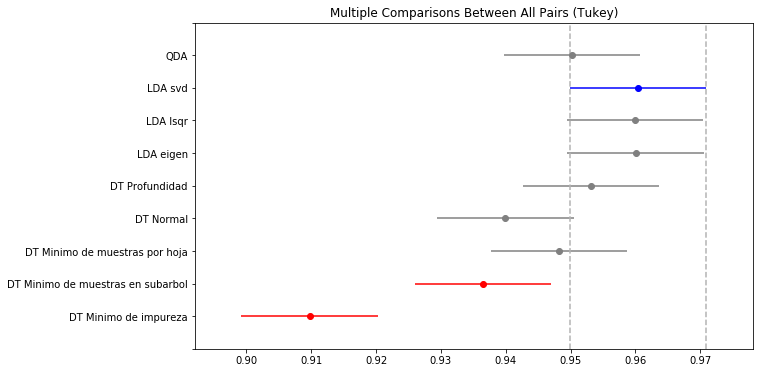

In [22]:
result,best_group = tukey_test(res_test, 0, 9, etiquetas)

Figure(720x432)


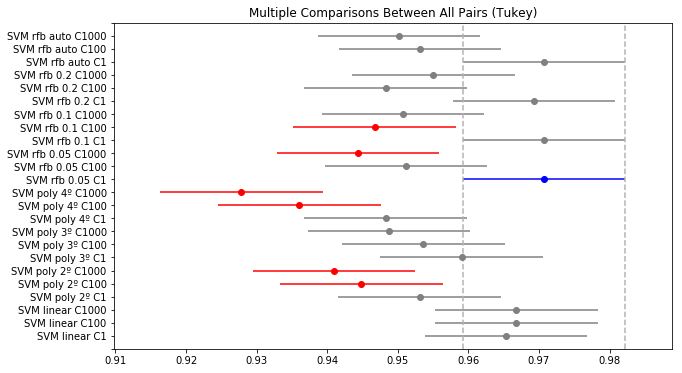

In [23]:
result, best_group = tukey_test(res_test, 9, 33, etiquetas)

Figure(720x432)


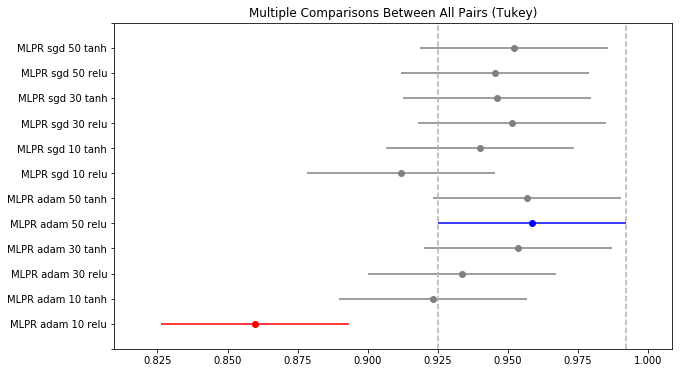

In [24]:
result, best_group = tukey_test(res_test, 33, 45, etiquetas)

In [84]:
# Ej: Para los 8 primeros modelos, min_i = 0, max_i = 9.
def tukey_best(res_test, simple_best, etiquetas):
    simple_idx = [etiquetas.index(simple_tag) for simple_tag in simple_best]
    # Para obtener los scores de test de los modelos indicados (30 de cada)
    test = []
    for simple_tag in simple_idx:
        test += [res_test[i][simple_tag] for i in range(res_test.shape[0])]
    flat_test = np.array(test)
    tags = [tag for tag in simple_best for _ in range(res_test.shape[0])]
    # seleccionamos el que tiene mejor media y vemos en el anterior cuales son iguales
    best_group = np.argmax(np.mean(flat_test.reshape((len(simple_best), 30),order='C'), axis=1))
    best_group = tags[int(best_group)*res_test.shape[0]]
    result = pairwise_tukeyhsd(flat_test,tags)
    print(result.plot_simultaneous(comparison_name=best_group))
    return (result,best_group)

In [26]:
simple_best = ['LDA svd', 'SVM linear C1', 'MLPR sgd 10 relu']

Figure(720x432)


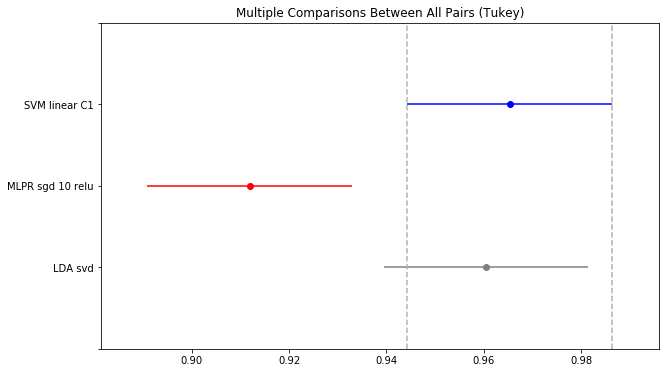

In [81]:
result, best_group = tukey_best(res_test, simple_best, etiquetas)

Figure(720x432)


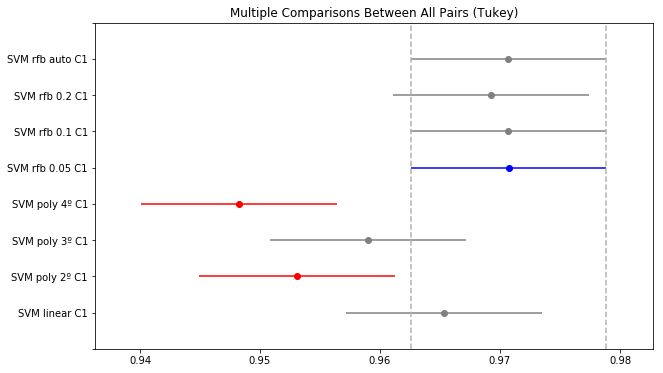

In [85]:
svm_list =  ['SVM linear C1',
             'SVM poly 2º C1',
             'SVM poly 3º C1',
             'SVM poly 4º C1',
             'SVM rfb auto C1',
             'SVM rfb 0.05 C1',
             'SVM rfb 0.1 C1',
             'SVM rfb 0.2 C1']
result, best_group = tukey_best(res_test, svm_list, etiquetas)

In [63]:
labels = [etiquetas[i] for i in range(res_test.shape[1]) for _ in range(res_test.shape[0])]
arr_test = res_test.flatten('F')
resultados = pairwise_tukeyhsd(arr_test,labels)
# resultados.summary()

In [37]:
#seleccionamos el que tiene mejor media y vemos en el anterior cuales son iguales
best_group = np.argmax(np.mean(res_test, axis = 0))
best_group = etiquetas[int(best_group)]

Figure(720x432)


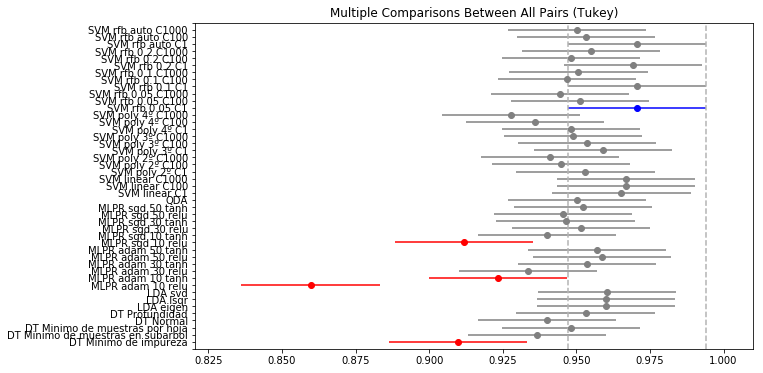

In [38]:
print(resultados.plot_simultaneous(comparison_name=best_group))

In [39]:
resultados = resultados._results_table.data

In [40]:
group1 = resultados[0].index('group1')
group2 = resultados[0].index('group2')
reject = resultados[0].index('reject')
best_groups = []
for row in resultados[1:]:
    if (row[group1] == str(best_group) or row[group2] == str(best_group)) and not row[reject]:
        best_groups.append(row[group1])
        best_groups.append(row[group2])
best_groups.append(best_group)
best_groups = set(best_groups)
sorted(best_groups)

['DT Minimo de muestras en subarbol',
 'DT Minimo de muestras por hoja',
 'DT Normal',
 'DT Profundidad',
 'LDA eigen',
 'LDA lsqr',
 'LDA svd',
 'MLPR adam 30 relu',
 'MLPR adam 30 tanh',
 'MLPR adam 50 relu',
 'MLPR adam 50 tanh',
 'MLPR sgd 10 tanh',
 'MLPR sgd 30 relu',
 'MLPR sgd 30 tanh',
 'MLPR sgd 50 relu',
 'MLPR sgd 50 tanh',
 'QDA',
 'SVM linear C1',
 'SVM linear C100',
 'SVM linear C1000',
 'SVM poly 2º C1',
 'SVM poly 2º C100',
 'SVM poly 2º C1000',
 'SVM poly 3º C1',
 'SVM poly 3º C100',
 'SVM poly 3º C1000',
 'SVM poly 4º C1',
 'SVM poly 4º C100',
 'SVM poly 4º C1000',
 'SVM rfb 0.05 C1',
 'SVM rfb 0.05 C100',
 'SVM rfb 0.05 C1000',
 'SVM rfb 0.1 C1',
 'SVM rfb 0.1 C100',
 'SVM rfb 0.1 C1000',
 'SVM rfb 0.2 C1',
 'SVM rfb 0.2 C100',
 'SVM rfb 0.2 C1000',
 'SVM rfb auto C1',
 'SVM rfb auto C100',
 'SVM rfb auto C1000']

**Nos quedamos con el más sencillo**  
El cual asumimos que es el Lineal Discriminant Analysis con lsqr (Minimos cuadrados)

In [41]:
def performance_indexes(CM, PositiveClass):
    classNum = len(CM)
    TP = CM[PositiveClass, PositiveClass]
    TN = 0
    FP = 0
    FN = 0
    for real in range(classNum):
        for predicted in range(classNum):
            if (real != PositiveClass and predicted != PositiveClass):
                TN += CM[real, predicted]
            if (real != PositiveClass and predicted == PositiveClass):
                FP += CM[real, predicted]
            if (real == PositiveClass and predicted != PositiveClass):
                FN += CM[real, predicted]
    Sens = TP/(TP+FN)
    Spec = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    return Sens,Spec,PPV,NPV,ACC

In [42]:
# Escogemos el modelo más simple de entre los mejores
simple = etiquetas.index('LDA svd')
tipo = 'svd'
Sens_l = []
Spec_l = []
PPV_l = []
NPV_l = []
ACC_l = []
for test_index in test_indices[simple]:
    train_index = np.ones(y.shape, dtype=bool)
    train_index[test_index] = False
    X_test, y_test = X[test_index], y[test_index]
    X_train, y_train = X[train_index], y[train_index]
    alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
    alg.fit(X_train, y_train)
    y_pred = alg.predict(X_test)
    CM = confusion_matrix(y_test, y_pred)
    Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,1)
    Sens_l.append(Sens)
    Spec_l.append(Spec)
    PPV_l.append(PPV)
    NPV_l.append(NPV)
    ACC_l.append(ACC)
print(('Sens: {:.2f}, Spec: {:.2f}, ' +
       'PPV: {:.2f}, NPV: {:.2f}, ACC: {:.2f}').format(np.mean(Sens_l),
                                                       np.mean(Spec_l),
                                                       np.mean(PPV_l),
                                                       np.mean(NPV_l),
                                                       np.mean(ACC_l)))


Sens: 0.92, Spec: 0.98, PPV: 0.97, NPV: 0.96, ACC: 0.96


----------------------------------------------------------------------------------------------------------------------------

In [43]:
for ind, tag in enumerate(etiquetas):
    mean_test = np.mean(res_test[:,ind])
    std_test = np.std(res_test[:,ind])
    print('{}: {:.2f} +- {:.2f}'.format(tag, mean_test, std_test))

DT Normal: 0.94 +- 0.03
DT Profundidad: 0.95 +- 0.02
DT Minimo de muestras por hoja: 0.95 +- 0.02
DT Minimo de muestras en subarbol: 0.94 +- 0.03
DT Minimo de impureza: 0.91 +- 0.03
LDA lsqr: 0.96 +- 0.03
LDA eigen: 0.96 +- 0.02
LDA svd: 0.96 +- 0.02
QDA: 0.95 +- 0.03
SVM linear C1: 0.97 +- 0.02
SVM poly 2º C1: 0.95 +- 0.02
SVM poly 3º C1: 0.96 +- 0.02
SVM poly 4º C1: 0.95 +- 0.03
SVM rfb auto C1: 0.97 +- 0.02
SVM rfb 0.05 C1: 0.97 +- 0.02
SVM rfb 0.1 C1: 0.97 +- 0.02
SVM rfb 0.2 C1: 0.97 +- 0.02
SVM linear C100: 0.97 +- 0.02
SVM poly 2º C100: 0.94 +- 0.04
SVM poly 3º C100: 0.95 +- 0.03
SVM poly 4º C100: 0.94 +- 0.03
SVM rfb auto C100: 0.95 +- 0.02
SVM rfb 0.05 C100: 0.95 +- 0.02
SVM rfb 0.1 C100: 0.95 +- 0.03
SVM rfb 0.2 C100: 0.95 +- 0.02
SVM linear C1000: 0.97 +- 0.02
SVM poly 2º C1000: 0.94 +- 0.02
SVM poly 3º C1000: 0.95 +- 0.03
SVM poly 4º C1000: 0.93 +- 0.03
SVM rfb auto C1000: 0.95 +- 0.03
SVM rfb 0.05 C1000: 0.94 +- 0.03
SVM rfb 0.1 C1000: 0.95 +- 0.02
SVM rfb 0.2 C1000: 0.96 

## FIN